In [12]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import networkx as nx
from pyscipopt import Model
from pyscipopt import quicksum
import platform
import time  

In [13]:
def euclidean_dist(u,v):
    dis=pow((u[0]-v[0]),2)+pow((u[1]-v[1]),2)
    return np.sqrt(dis)
def euclidean_dist_square(u,v):
    dis=pow((u[0]-v[0]),2)+pow((u[1]-v[1]),2)
    return dis

In [14]:
def write_file(G,distance_type,i):
    size=len(G.nodes())
    with open("tri_graph_label_"+str(i)+"_size_"+str(size)+"_"+distance_type+".gph","w+") as f:
        for i in range(0,size):
            f.write("V "+str(i)+"\n")
        for (u,v) in G.edges():
            f.write("E "+str(u)+" "+str(v)+" "+str(G.edges[(u,v)]["cost"])+"\n")
        for i in range(1,size-1):
            f.write("D "+str(i) +" "+str(G.nodes[i]["weight"])+"\n")




In [15]:
def Del_Tri_Euclid(n):
    G=nx.Graph()
    # Generate some random points as an example
    np.random.seed(np.random.randint(low=1,high=101))
    points = 100*np.random.rand(n, 2)
    # Perform Delaunay triangulation
    G.add_node(0,pos=points[0],weight=0)
    G.add_node(n-1,pos=points[n-1],weight=0)
    for i in range(1,n-1):
        G.add_node(i,pos=points[i],weight=round(np.random.rand(),2))
    triangulation = Delaunay(points)
    edges = set()
    for simplex in triangulation.simplices:
        # Iterate over all edges of the simplex (triangle)
        for i in range(3):
            # Ensure that the edge is sorted in ascending order to avoid duplicates
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            w=round(euclidean_dist(points[edge[0]],points[edge[1]]),2)
            G.add_edge(edge[0],edge[1],cost=w)
    #labels = {n: G.nodes[n]["weight"] for n in G.nodes}
    #colors = [G.nodes[n]["weight"] for n in G.nodes]
    #nx.draw(G, with_labels=True, labels=labels, node_color=colors)
    return G

In [16]:
def Del_Tri_Euclid_Square(n):
    G=nx.Graph()
    # Generate some random points as an example
    np.random.seed(np.random.randint(low=1,high=101))
    points = 100*np.random.rand(n, 2)
    # Perform Delaunay triangulation
    triangulation = Delaunay(points)
    G.add_node(0,pos=points[0],weight=0)
    G.add_node(n-1,pos=points[n-1],weight=0)
    for i in range(1,n-1):
        G.add_node(i,pos=points[i],weight=round(np.random.rand(),2))
    edges = set()
    for simplex in triangulation.simplices:
        # Iterate over all edges of the simplex (triangle)
        for i in range(3):
            # Ensure that the edge is sorted in ascending order to avoid duplicates
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            w=round(euclidean_dist_square(points[edge[0]],points[edge[1]]),2)
            G.add_edge(edge[0],edge[1],cost=w)
    #labels = {n: G.nodes[n]["weight"] for n in G.nodes}
    #colors = [G.nodes[n]["weight"] for n in G.nodes]
    #nx.draw(G, with_labels=True, labels=labels, node_color=colors)
    return G

In [17]:
def new_lp(G):
    n=len(G.nodes())
    s=0
    t=n-1
    Q=0.25*np.sqrt(n)
    Demand={}
    for v in G.nodes():
        if v !=s and v!=t:
            Demand[v]=G.nodes[v]["weight"]
    temp=float(Demand[1])
    for i in Demand.keys():
        temp=min(float(Demand[i]),temp)
    model=Model("RCSPP")
    x={}
    y={}
    for u,v in G.edges():
        x[(u,v)]=model.addVar(name=f'x_{u}_{v}',lb=0,ub=1)
        x[(v,u)]=model.addVar(name=f'x_{v}_{u}',lb=0,ub=1)
        y[(u,v)]=model.addVar(name=f'y_{u}_{v}',lb=0)
        y[(v,u)]=model.addVar(name=f'y_{v}_{u}',lb=0)
    for v in G.nodes():
        if v!=s and v!=t:
            model.addCons(quicksum(x[(u,v)] for u in G.neighbors(v))==quicksum(x[(v,u)] for u in G.neighbors(v)))
            model.addCons(Demand[v]*quicksum(x[(u,v)]+x[(v,u)] for u in G.neighbors(v))==quicksum(y[(u,v)]-y[(v,u)] for u in G.neighbors(v)))
    model.addCons(quicksum(x[(u,s)] for u in G.neighbors(s))==quicksum(x[(s,u)] for u in G.neighbors(s))-1)
    model.addCons(quicksum(x[(u,t)] for u in G.neighbors(t))==quicksum(x[(t,u)] for u in G.neighbors(t))+1)
    model.addCons(quicksum(x[(s,u)] for u in G.neighbors(s)) == 1)
    model.addCons(quicksum(y[(s,u)] for u in G.neighbors(s)) == Q)
    model.addCons(quicksum(x[(t,u)] for u in G.neighbors(t)) == 0)
    for u in Demand.keys():
        for v in G.neighbors(u):
            if v!=s and v!=t:
                model.addCons(y[(u,v)]>=temp*(x[(u,v)]+x[(v,u)]))
                model.addCons(y[(v,u)]>=temp*(x[(u,v)]+x[(v,u)]))
    for u,v in G.edges():
        model.addCons(Q*(x[(u,v)]+x[(v,u)])==(y[(u,v)]+y[(v,u)]))
    model.setObjective(quicksum((x[(u,v)]+x[(v,u)])*G.edges[(u,v)]['cost'] for u,v in G.edges()))
    return model

  

In [18]:
def new_ip(G):
    n=len(G.nodes())
    s=0
    t=n-1
    Q=0.25*np.sqrt(n)
    Demand={}
    for v in G.nodes():
        if v !=s and v!=t:
            Demand[v]=G.nodes[v]["weight"]
    temp=float(Demand[1])
    for i in Demand.keys():
        temp=min(float(Demand[i]),temp)
    model=Model("RCSPP")
    x={}
    y={}
    for u,v in G.edges():
        x[(u,v)]=model.addVar(name=f'x_{u}_{v}',vtype='B')
        x[(v,u)]=model.addVar(name=f'x_{v}_{u}',vtype='B')
        y[(u,v)]=model.addVar(name=f'y_{u}_{v}',lb=0)
        y[(v,u)]=model.addVar(name=f'y_{v}_{u}',lb=0)
    for v in G.nodes():
        if v!=s and v!=t:
            model.addCons(quicksum(x[(u,v)] for u in G.neighbors(v))==quicksum(x[(v,u)] for u in G.neighbors(v)))
            model.addCons(Demand[v]*quicksum(x[(u,v)]+x[(v,u)] for u in G.neighbors(v))==quicksum(y[(u,v)]-y[(v,u)] for u in G.neighbors(v)))
    model.addCons(quicksum(x[(u,s)] for u in G.neighbors(s))==quicksum(x[(s,u)] for u in G.neighbors(s))-1)
    model.addCons(quicksum(x[(u,t)] for u in G.neighbors(t))==quicksum(x[(t,u)] for u in G.neighbors(t))+1)
    model.addCons(quicksum(x[(s,u)] for u in G.neighbors(s)) == 1)
    model.addCons(quicksum(y[(s,u)] for u in G.neighbors(s)) == Q)
    model.addCons(quicksum(x[(t,u)] for u in G.neighbors(t)) == 0)
    for u in Demand.keys():
        for v in G.neighbors(u):
            model.addCons(y[(u,v)]>=temp*(x[(u,v)]+x[(v,u)]))
            model.addCons(y[(v,u)]>=temp*(x[(u,v)]+x[(v,u)]))
    for u,v in G.edges():
        model.addCons(Q*(x[(u,v)]+x[(v,u)])==(y[(u,v)]+y[(v,u)]))
    model.setObjective(quicksum((x[(u,v)]+x[(v,u)])*G.edges[(u,v)]['cost'] for u,v in G.edges()))
    return model

In [19]:
def traditional_lp(G):    
    n=len(G.nodes())
    s=0
    t=n-1
    Q=0.25*np.sqrt(n)
    Demand={}
    for v in G.nodes():
        if v !=s and v!=t:
            Demand[v]=G.nodes[v]["weight"]
    model=Model("RCSPP")
    x={}
    for u,v in G.edges():
        x[(u,v)]=model.addVar(name=f'x_{u}_{v}',lb=0,ub=1)
        x[(v,u)]=model.addVar(name=f'x_{v}_{u}',lb=0,ub=1)
    for v in G.nodes():
        if v!=s and v!=t:
            model.addCons(quicksum(x[(u,v)] for u in G.neighbors(v))==quicksum(x[(v,u)] for u in G.neighbors(v)))
    model.addCons(quicksum(x[(u,s)] for u in G.neighbors(s))==quicksum(x[(s,u)] for u in G.neighbors(s))-1)
    model.addCons(quicksum(x[(u,t)] for u in G.neighbors(t))==quicksum(x[(t,u)] for u in G.neighbors(t))+1)
    model.addCons(quicksum(x[(s,u)] for u in G.neighbors(s)) == 1)
    model.addCons(quicksum(x[(t,u)] for u in G.neighbors(t)) == 0)
    for u,v in G.edges():
        model.addCons(x[(u,v)]+x[(v,u)]<=1)
    model.addCons(quicksum(Demand[v]*quicksum(x[(u,v)]+x[(v,u)] for u in G.neighbors(v)) for v in Demand)<=2*Q)
    model.setObjective(quicksum((x[(u,v)]+x[(v,u)])*G.edges[(u,v)]['cost'] for u,v in G.edges()))
    return model

    

In [20]:
def traditional_ip(G):    
    n=len(G.nodes())
    s=0
    t=n-1
    Q=0.25*np.sqrt(n)
    Demand={}
    for v in G.nodes():
        if v !=s and v!=t:
            Demand[v]=G.nodes[v]["weight"]
    model=Model("RCSPP")
    x={}
    for u,v in G.edges():
        x[(u,v)]=model.addVar(name=f'x_{u}_{v}',vtype='B')
        x[(v,u)]=model.addVar(name=f'x_{v}_{u}',vtype='B')
    for v in G.nodes():
        if v!=s and v!=t:
            model.addCons(quicksum(x[(u,v)] for u in G.neighbors(v))==quicksum(x[(v,u)] for u in G.neighbors(v)))
    model.addCons(quicksum(x[(u,s)] for u in G.neighbors(s))==quicksum(x[(s,u)] for u in G.neighbors(s))-1)
    model.addCons(quicksum(x[(u,t)] for u in G.neighbors(t))==quicksum(x[(t,u)] for u in G.neighbors(t))+1)
    model.addCons(quicksum(x[(s,u)] for u in G.neighbors(s)) == 1)
    model.addCons(quicksum(x[(t,u)] for u in G.neighbors(t)) == 0)
    for u,v in G.edges():
        model.addCons(x[(u,v)]+x[(v,u)]<=1)
    model.addCons(quicksum(Demand[v]*quicksum(x[(u,v)]+x[(v,u)] for u in G.neighbors(v)) for v in Demand)<=2*Q)
    model.setObjective(quicksum((x[(u,v)]+x[(v,u)])*G.edges[(u,v)]['cost'] for u,v in G.edges()))
    return model

In [21]:
import random

optimal
['T_new', 0.1250765323638916, 'T_trad', 0.03755760192871094, True]
optimal
['T_new', 0.3273615837097168, 'T_trad', 0.06497812271118164, True]
optimal
['T_new', 0.18381118774414062, 'T_trad', 0.04497241973876953, True]
optimal
['T_new', 0.13608884811401367, 'T_trad', 0.032535552978515625, True]
optimal
['T_new', 0.09478592872619629, 'T_trad', 0.023021936416625977, True]
optimal
['T_new', 0.14539527893066406, 'T_trad', 0.04555320739746094, True]
optimal
['T_new', 0.28504467010498047, 'T_trad', 0.05966472625732422, True]
optimal
['T_new', 0.3338191509246826, 'T_trad', 0.07810425758361816, True]
optimal
['T_new', 0.2406153678894043, 'T_trad', 0.06117367744445801, True]
optimal
['T_new', 0.33552050590515137, 'T_trad', 0.07854676246643066, True]
infeasible
optimal
['T_new', 0.05659198760986328, 'T_trad', 0.01651597023010254, True]
optimal
['T_new', 0.26224493980407715, 'T_trad', 0.06658172607421875, True]
optimal
['T_new', 0.30796051025390625, 'T_trad', 0.05019187927246094, True]
opt

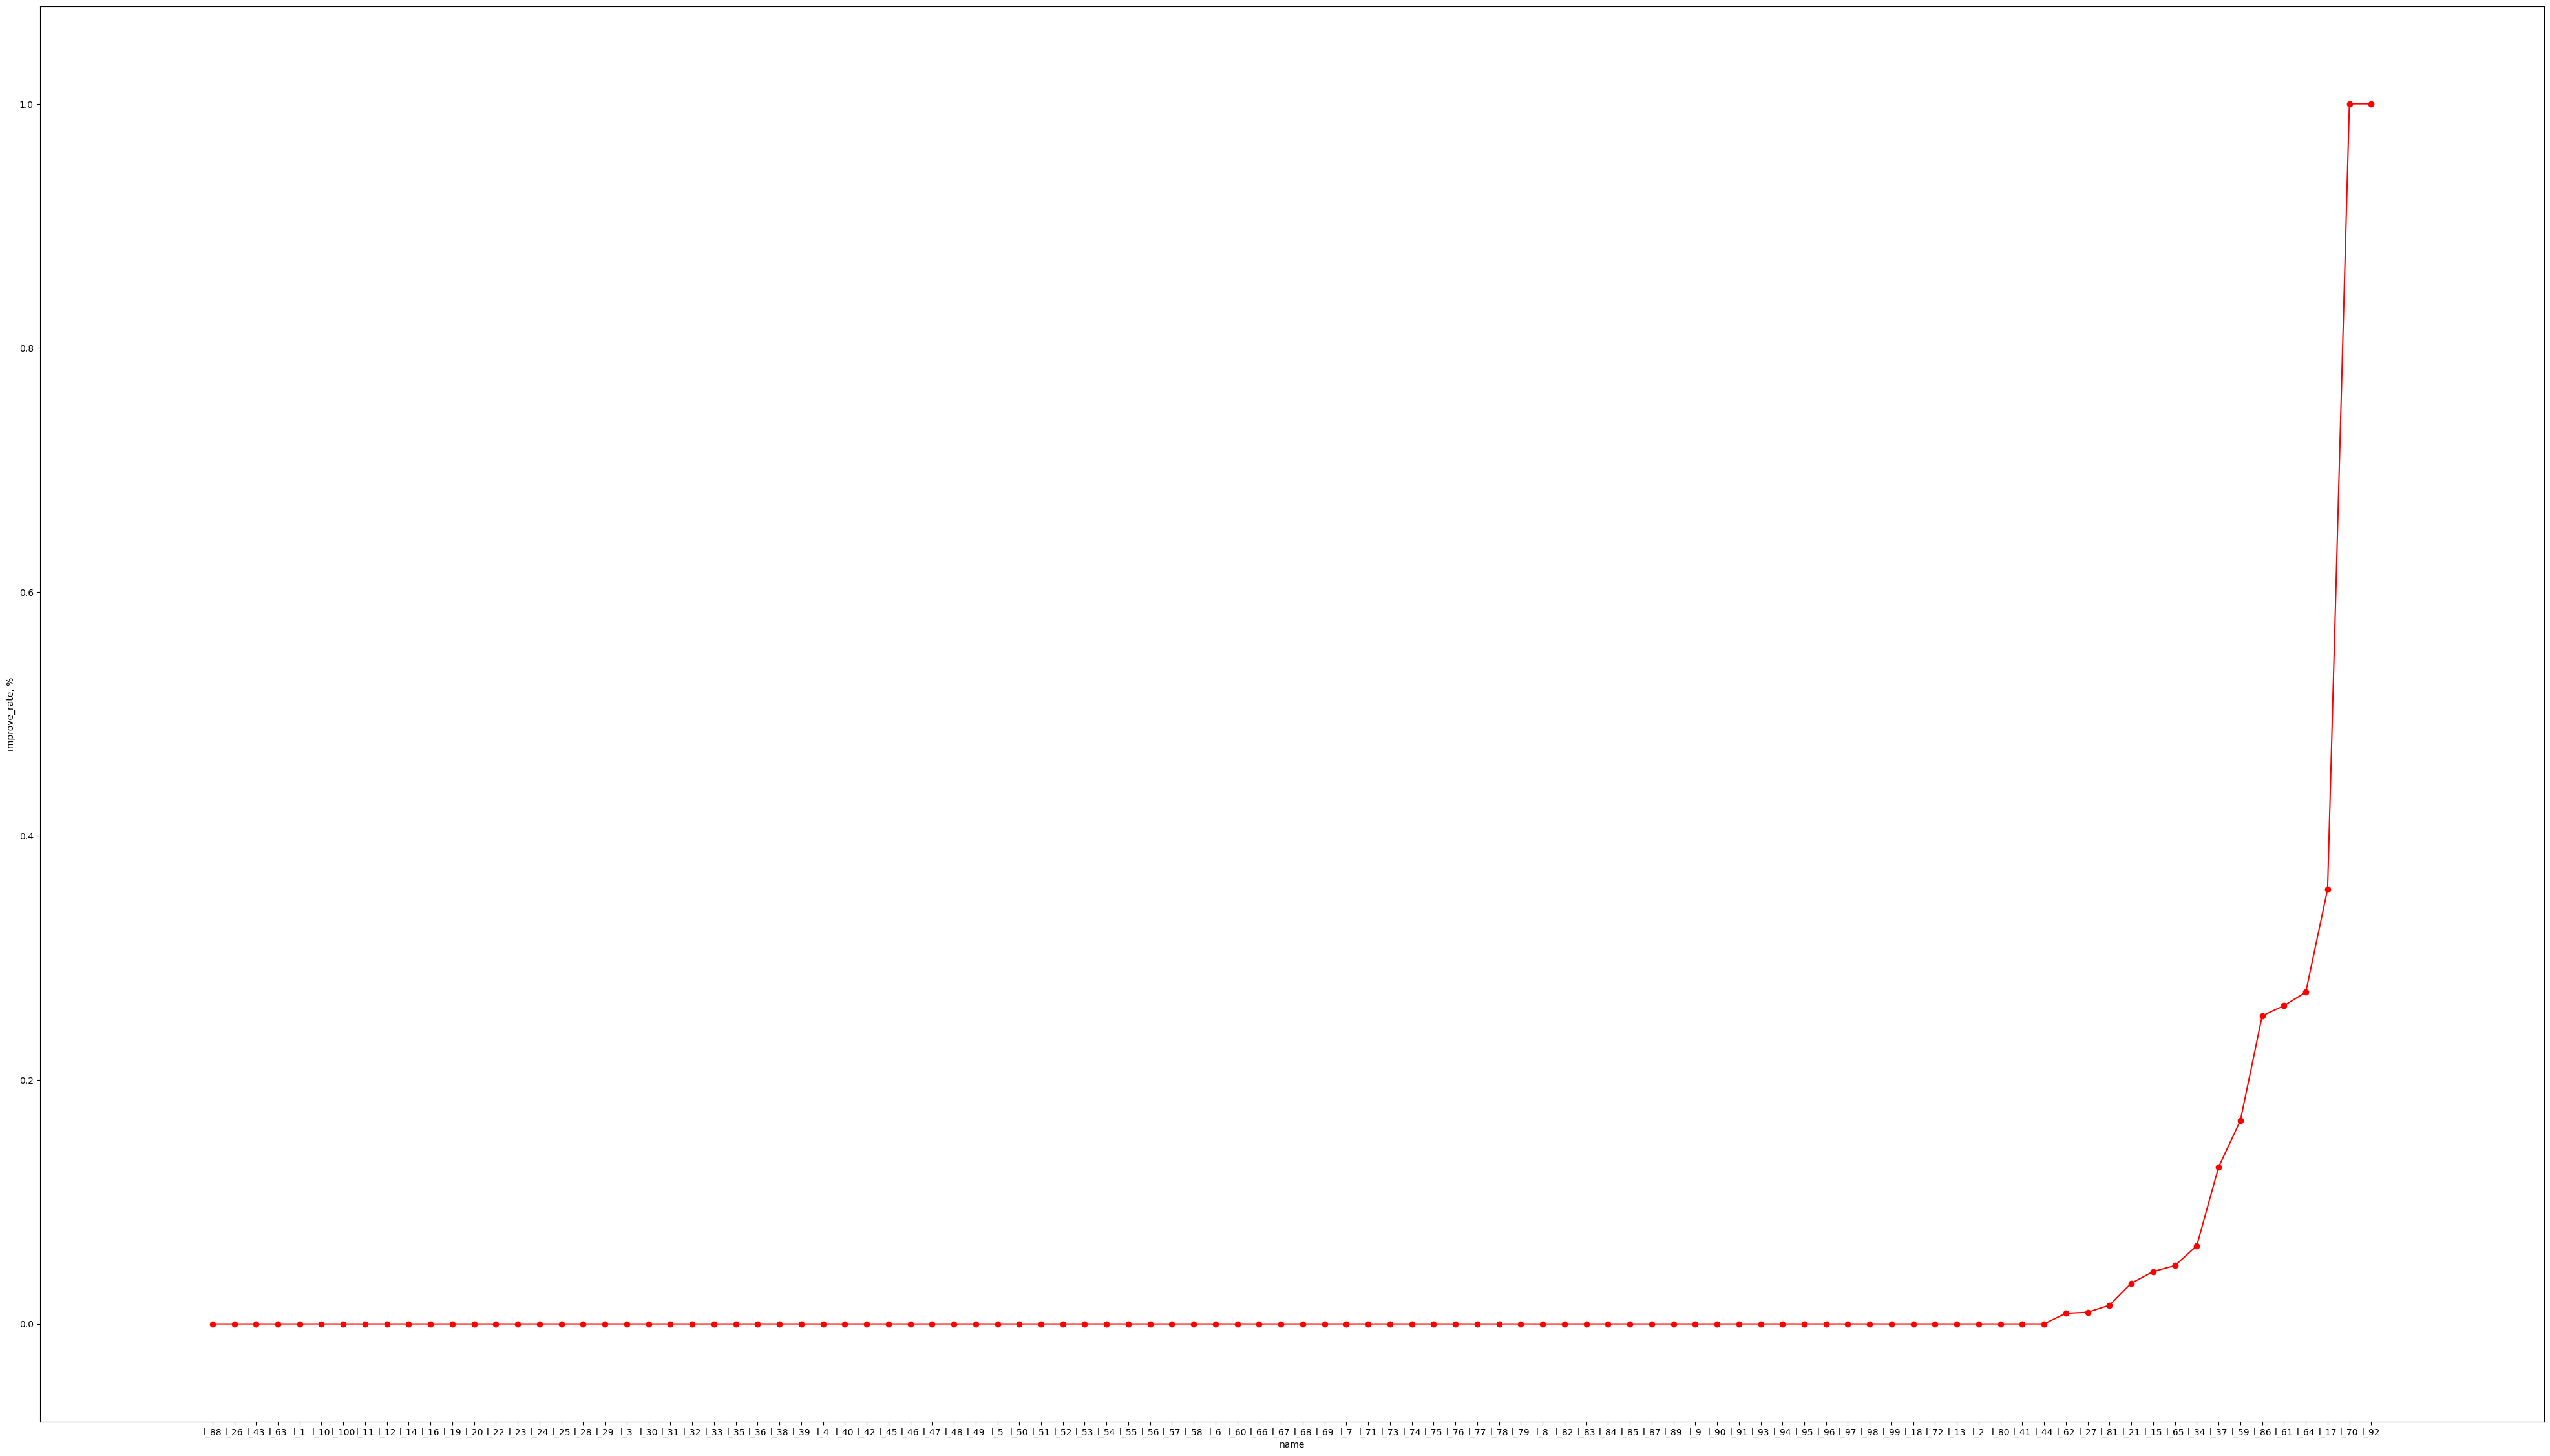

{1: 2.3302587476512113, 2: 4.038027724574188, 3: 3.087198082999343, 4: 3.182773478719662, 5: 3.1172005260923146, 6: 2.1917682033245405, 7: 3.777440340137142, 8: 3.2740198966400382, 9: 2.9333154052716295, 10: 3.2716019778478613, 11: 2.426500945534335, 12: 2.9386924200756273, 13: 5.135664069922098, 14: 2.9528337373568503, 15: 4.018374320973075, 16: 1.6820667486805032, 17: 4.622101091791347, 18: 13.799208590804168, 19: 3.84666812322482, 20: 4.468251262491743, 21: 14.298075350708768, 22: 3.070349160900342, 23: 3.159073654030246, 24: 6.364162186190255, 25: 8.41388457902139, 26: 7.2049972175848636, 27: 5.018055500819169, 28: 2.800730273245745, 29: 3.910882545476186, 30: 1.8636805408831607, 31: 2.073054192017589, 32: 2.25263874890629, 33: 1.9945384655523282, 34: 2.075525299766533, 35: 2.95098258250744, 36: 3.2757154994418265, 37: 2.9143224369135856, 38: 4.1246542561456945, 39: 5.5422717583186225, 40: 3.2443171596534293, 41: 5.1830557554573184, 42: 16.81018447205299, 43: 9.763612160769496, 44:

In [22]:
i=1
improved_gap={}
traditional_model_gap={}
time_gap_lp={}
time_gap_ip={}
improve_gap={}
L1=random.sample(range(100,1000),100)
diff=[]
while i<=100:
    k=L1[i-1]
    G=Del_Tri_Euclid(k)
    size=len(G.nodes())
    new_lp_model=new_lp(G)
    new_ip_model=new_ip(G)
    traditional_lp_model=traditional_lp(G)
    traditional_ip_model=traditional_ip(G)
    T1=time.time()
    new_lp_model.optimize()
    T2=time.time()
    new_ip_model.optimize()
    T3=time.time()
    traditional_lp_model.optimize()
    T4=time.time()
    traditional_ip_model.optimize()
    T5=time.time()
    print(new_ip_model.getStatus())
    if new_ip_model.getStatus()=="optimal":
        object1=new_lp_model.getObjVal()
        object2=new_ip_model.getObjVal()
        object3=traditional_lp_model.getObjVal()
        object4=traditional_ip_model.getObjVal()
        write_file(G,"euclidean_dist",i)
        assert abs(object2-object4)<=1e-6
        graph_name="tri_graph_size_"+str(size)+"_label_"+str(i)
        improved_gap[i]=(object1-object3)/object3
        traditional_model_gap[i]=(object4-object3)/object3
        diff.append(object4-object2)
        if traditional_model_gap[i]==0:
            improve_gap["l_"+str(i)]=0
        else:
            improve_gap["l_"+str(i)]=improved_gap[i]/traditional_model_gap[i]
        time_gap_lp[i]=((T2-T1)-(T4-T3))/(T4-T3)
        time_gap_ip[i]=((T3-T2)-(T5-T4))/(T5-T4)
        print(["T_new",T2-T1,"T_trad",T4-T3,abs(T2-T1)>1e-10])
        i=i+1
    else:
        pass
improve_gap_sorted=sorted(improve_gap.items(), key = lambda kv:(kv[1], kv[0]))
names=[]
gaps=[]
for i in range(0,len(improve_gap_sorted)):
    names.append(improve_gap_sorted[i][0])
    gaps.append(improve_gap_sorted[i][1])
x = range(len(names))
fig, ax = plt.subplots(figsize=(50,30))
plt.plot(x, gaps, 'ro-')
plt.xticks(x, names, rotation=0)
plt.margins(0.08)
plt.xlabel('name')
plt.ylabel('improve_rate, %')
plt.subplots_adjust(bottom=0.15)
plt.show()
fig.savefig('xx.png')
print(time_gap_lp)
print(time_gap_ip)
print(diff)


        
        
   